# Architektur Neuronales Netz

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            #nn.LayerNorm(hidden1_size),
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            #nn.LayerNorm(hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            #nn.LayerNorm(hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 1)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=5, out_features=200, bias=True)
    (2): Tanh()
    (3): Linear(in_features=200, out_features=200, bias=True)
    (4): Tanh()
    (5): Linear(in_features=200, out_features=200, bias=True)
    (6): Tanh()
    (7): Linear(in_features=200, out_features=1, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 32 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs xi
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
xi = torch.tensor(res['xi'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000

# T = torch.tensor(res['T']).float()
# p = torch.tensor(res['p']).float()
# x_0 = torch.tensor(res['x_0']).float()
# xi = torch.tensor(res['xi']).float()

# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = xi.reshape((-1,1))
#print(x_input.size())
# print(xi.size())

# Tensoren zu einem großen Set gruppieren
dataset = TensorDataset(x_input, y_output)

# for x,y in dataset:
#     print(x)
#     print(y)
    
# Split in Trainings und Test Set
train_dataset, test_dataset = random_split(dataset, 
                                           [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
                                           generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 1)

# Loss Funktion; gibt Fehler an
loss_fn = nn.MSELoss()
#loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)

#### Funktion zur Bestimmung der Genauigkeit

In [7]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
            #print(pred.size())
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred, y)

            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if pred[i] - y[i] <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f} \n")

    net.train()
    
    return acc, loss, MRE

#### Training

In [8]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients

#         # Record the correct predictions for training data
#         _, predictions = torch.max(pred.data, 1)
#         train_correct += (predictions == y.data).sum()                
#         train_total += predictions.size(0)    

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping
    #train_loss.append(loss.item())
    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)

#     loss = criterion(outputs, Variable(test_classes))
#     test_loss.append(loss.data[0])

Epoch 1/200, Iteration 1/25, Loss: 0.0384
Epoch 1/200, Iteration 2/25, Loss: 1.5121
Epoch 1/200, Iteration 3/25, Loss: 10.1550
Epoch 1/200, Iteration 4/25, Loss: 2.6768
Epoch 1/200, Iteration 5/25, Loss: 0.1011
Epoch 1/200, Iteration 6/25, Loss: 0.1813
Epoch 1/200, Iteration 7/25, Loss: 0.2696
Epoch 1/200, Iteration 8/25, Loss: 0.1000
Epoch 1/200, Iteration 9/25, Loss: 0.1026
Epoch 1/200, Iteration 10/25, Loss: 0.1240
Epoch 1/200, Iteration 11/25, Loss: 0.1974
Epoch 1/200, Iteration 12/25, Loss: 0.0923
Epoch 1/200, Iteration 13/25, Loss: 0.0974
Epoch 1/200, Iteration 14/25, Loss: 0.0987
Epoch 1/200, Iteration 15/25, Loss: 0.1114
Epoch 1/200, Iteration 16/25, Loss: 0.1176
Epoch 1/200, Iteration 17/25, Loss: 0.1690
Epoch 1/200, Iteration 18/25, Loss: 0.1087
Epoch 1/200, Iteration 19/25, Loss: 0.0809
Epoch 1/200, Iteration 20/25, Loss: 0.0508
Epoch 1/200, Iteration 21/25, Loss: 0.0397
Epoch 1/200, Iteration 22/25, Loss: 0.0223
Epoch 1/200, Iteration 23/25, Loss: 0.0529
Epoch 1/200, Iterat

Train Error: 
 Accuracy: 31.13%, Avg loss: 0.003473, MRE: 4.248296 

Test Error: 
 Accuracy: 25.5%, Avg loss: 0.003294, MRE: 6.727815 

Epoch 8/200, Iteration 1/25, Loss: 0.0049
Epoch 8/200, Iteration 2/25, Loss: 0.0023
Epoch 8/200, Iteration 3/25, Loss: 0.0038
Epoch 8/200, Iteration 4/25, Loss: 0.0035
Epoch 8/200, Iteration 5/25, Loss: 0.0013
Epoch 8/200, Iteration 6/25, Loss: 0.0022
Epoch 8/200, Iteration 7/25, Loss: 0.0025
Epoch 8/200, Iteration 8/25, Loss: 0.0043
Epoch 8/200, Iteration 9/25, Loss: 0.0042
Epoch 8/200, Iteration 10/25, Loss: 0.0064
Epoch 8/200, Iteration 11/25, Loss: 0.0032
Epoch 8/200, Iteration 12/25, Loss: 0.0017
Epoch 8/200, Iteration 13/25, Loss: 0.0103
Epoch 8/200, Iteration 14/25, Loss: 0.0083
Epoch 8/200, Iteration 15/25, Loss: 0.0013
Epoch 8/200, Iteration 16/25, Loss: 0.0010
Epoch 8/200, Iteration 17/25, Loss: 0.0009
Epoch 8/200, Iteration 18/25, Loss: 0.0031
Epoch 8/200, Iteration 19/25, Loss: 0.0024
Epoch 8/200, Iteration 20/25, Loss: 0.0028
Epoch 8/200, 

Train Error: 
 Accuracy: 35.5%, Avg loss: 0.005174, MRE: 4.153125 

Test Error: 
 Accuracy: 29.5%, Avg loss: 0.004794, MRE: 7.631465 

Epoch 15/200, Iteration 1/25, Loss: 0.0055
Epoch 15/200, Iteration 2/25, Loss: 0.0005
Epoch 15/200, Iteration 3/25, Loss: 0.0053
Epoch 15/200, Iteration 4/25, Loss: 0.0014
Epoch 15/200, Iteration 5/25, Loss: 0.0030
Epoch 15/200, Iteration 6/25, Loss: 0.0011
Epoch 15/200, Iteration 7/25, Loss: 0.0007
Epoch 15/200, Iteration 8/25, Loss: 0.0008
Epoch 15/200, Iteration 9/25, Loss: 0.0019
Epoch 15/200, Iteration 10/25, Loss: 0.0005
Epoch 15/200, Iteration 11/25, Loss: 0.0016
Epoch 15/200, Iteration 12/25, Loss: 0.0017
Epoch 15/200, Iteration 13/25, Loss: 0.0011
Epoch 15/200, Iteration 14/25, Loss: 0.0031
Epoch 15/200, Iteration 15/25, Loss: 0.0010
Epoch 15/200, Iteration 16/25, Loss: 0.0010
Epoch 15/200, Iteration 17/25, Loss: 0.0025
Epoch 15/200, Iteration 18/25, Loss: 0.0034
Epoch 15/200, Iteration 19/25, Loss: 0.0053
Epoch 15/200, Iteration 20/25, Loss: 0

Epoch 21/200, Iteration 23/25, Loss: 0.0026
Epoch 21/200, Iteration 24/25, Loss: 0.0004
Epoch 21/200, Iteration 25/25, Loss: 0.0034
Train Error: 
 Accuracy: 74.12%, Avg loss: 0.000622, MRE: 0.981400 

Test Error: 
 Accuracy: 72.0%, Avg loss: 0.000547, MRE: 1.716783 

Epoch 22/200, Iteration 1/25, Loss: 0.0013
Epoch 22/200, Iteration 2/25, Loss: 0.0012
Epoch 22/200, Iteration 3/25, Loss: 0.0004
Epoch 22/200, Iteration 4/25, Loss: 0.0006
Epoch 22/200, Iteration 5/25, Loss: 0.0021
Epoch 22/200, Iteration 6/25, Loss: 0.0032
Epoch 22/200, Iteration 7/25, Loss: 0.0010
Epoch 22/200, Iteration 8/25, Loss: 0.0012
Epoch 22/200, Iteration 9/25, Loss: 0.0005
Epoch 22/200, Iteration 10/25, Loss: 0.0014
Epoch 22/200, Iteration 11/25, Loss: 0.0012
Epoch 22/200, Iteration 12/25, Loss: 0.0003
Epoch 22/200, Iteration 13/25, Loss: 0.0013
Epoch 22/200, Iteration 14/25, Loss: 0.0014
Epoch 22/200, Iteration 15/25, Loss: 0.0008
Epoch 22/200, Iteration 16/25, Loss: 0.0028
Epoch 22/200, Iteration 17/25, Loss: 

Train Error: 
 Accuracy: 94.5%, Avg loss: 0.002012, MRE: 1.770974 

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.002308, MRE: 2.773326 

Epoch 29/200, Iteration 1/25, Loss: 0.0037
Epoch 29/200, Iteration 2/25, Loss: 0.0020
Epoch 29/200, Iteration 3/25, Loss: 0.0019
Epoch 29/200, Iteration 4/25, Loss: 0.0055
Epoch 29/200, Iteration 5/25, Loss: 0.0071
Epoch 29/200, Iteration 6/25, Loss: 0.0019
Epoch 29/200, Iteration 7/25, Loss: 0.0030
Epoch 29/200, Iteration 8/25, Loss: 0.0047
Epoch 29/200, Iteration 9/25, Loss: 0.0037
Epoch 29/200, Iteration 10/25, Loss: 0.0044
Epoch 29/200, Iteration 11/25, Loss: 0.0015
Epoch 29/200, Iteration 12/25, Loss: 0.0022
Epoch 29/200, Iteration 13/25, Loss: 0.0070
Epoch 29/200, Iteration 14/25, Loss: 0.0042
Epoch 29/200, Iteration 15/25, Loss: 0.0009
Epoch 29/200, Iteration 16/25, Loss: 0.0030
Epoch 29/200, Iteration 17/25, Loss: 0.0079
Epoch 29/200, Iteration 18/25, Loss: 0.0033
Epoch 29/200, Iteration 19/25, Loss: 0.0030
Epoch 29/200, Iteration 20/25, Loss: 0

Train Error: 
 Accuracy: 95.12%, Avg loss: 0.000212, MRE: 0.644485 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.000265, MRE: 1.571964 

Epoch 36/200, Iteration 1/25, Loss: 0.0010
Epoch 36/200, Iteration 2/25, Loss: 0.0005
Epoch 36/200, Iteration 3/25, Loss: 0.0003
Epoch 36/200, Iteration 4/25, Loss: 0.0003
Epoch 36/200, Iteration 5/25, Loss: 0.0008
Epoch 36/200, Iteration 6/25, Loss: 0.0004
Epoch 36/200, Iteration 7/25, Loss: 0.0004
Epoch 36/200, Iteration 8/25, Loss: 0.0006
Epoch 36/200, Iteration 9/25, Loss: 0.0010
Epoch 36/200, Iteration 10/25, Loss: 0.0008
Epoch 36/200, Iteration 11/25, Loss: 0.0003
Epoch 36/200, Iteration 12/25, Loss: 0.0007
Epoch 36/200, Iteration 13/25, Loss: 0.0006
Epoch 36/200, Iteration 14/25, Loss: 0.0005
Epoch 36/200, Iteration 15/25, Loss: 0.0003
Epoch 36/200, Iteration 16/25, Loss: 0.0001
Epoch 36/200, Iteration 17/25, Loss: 0.0007
Epoch 36/200, Iteration 18/25, Loss: 0.0004
Epoch 36/200, Iteration 19/25, Loss: 0.0002
Epoch 36/200, Iteration 20/25, Loss: 

Epoch 43/200, Iteration 9/25, Loss: 0.0025
Epoch 43/200, Iteration 10/25, Loss: 0.0006
Epoch 43/200, Iteration 11/25, Loss: 0.0009
Epoch 43/200, Iteration 12/25, Loss: 0.0004
Epoch 43/200, Iteration 13/25, Loss: 0.0014
Epoch 43/200, Iteration 14/25, Loss: 0.0011
Epoch 43/200, Iteration 15/25, Loss: 0.0005
Epoch 43/200, Iteration 16/25, Loss: 0.0005
Epoch 43/200, Iteration 17/25, Loss: 0.0004
Epoch 43/200, Iteration 18/25, Loss: 0.0009
Epoch 43/200, Iteration 19/25, Loss: 0.0013
Epoch 43/200, Iteration 20/25, Loss: 0.0016
Epoch 43/200, Iteration 21/25, Loss: 0.0005
Epoch 43/200, Iteration 22/25, Loss: 0.0002
Epoch 43/200, Iteration 23/25, Loss: 0.0011
Epoch 43/200, Iteration 24/25, Loss: 0.0013
Epoch 43/200, Iteration 25/25, Loss: 0.0004
Train Error: 
 Accuracy: 89.0%, Avg loss: 0.000116, MRE: 0.519147 

Test Error: 
 Accuracy: 86.0%, Avg loss: 0.000143, MRE: 1.181674 

Epoch 44/200, Iteration 1/25, Loss: 0.0007
Epoch 44/200, Iteration 2/25, Loss: 0.0006
Epoch 44/200, Iteration 3/25, Lo

Epoch 50/200, Iteration 20/25, Loss: 0.0012
Epoch 50/200, Iteration 21/25, Loss: 0.0013
Epoch 50/200, Iteration 22/25, Loss: 0.0001
Epoch 50/200, Iteration 23/25, Loss: 0.0001
Epoch 50/200, Iteration 24/25, Loss: 0.0007
Epoch 50/200, Iteration 25/25, Loss: 0.0013
Train Error: 
 Accuracy: 36.12%, Avg loss: 0.000740, MRE: 1.629891 

Test Error: 
 Accuracy: 30.0%, Avg loss: 0.000745, MRE: 3.009744 

Epoch 51/200, Iteration 1/25, Loss: 0.0009
Epoch 51/200, Iteration 2/25, Loss: 0.0004
Epoch 51/200, Iteration 3/25, Loss: 0.0001
Epoch 51/200, Iteration 4/25, Loss: 0.0002
Epoch 51/200, Iteration 5/25, Loss: 0.0004
Epoch 51/200, Iteration 6/25, Loss: 0.0008
Epoch 51/200, Iteration 7/25, Loss: 0.0004
Epoch 51/200, Iteration 8/25, Loss: 0.0007
Epoch 51/200, Iteration 9/25, Loss: 0.0004
Epoch 51/200, Iteration 10/25, Loss: 0.0004
Epoch 51/200, Iteration 11/25, Loss: 0.0003
Epoch 51/200, Iteration 12/25, Loss: 0.0006
Epoch 51/200, Iteration 13/25, Loss: 0.0007
Epoch 51/200, Iteration 14/25, Loss: 

Epoch 57/200, Iteration 18/25, Loss: 0.0005
Epoch 57/200, Iteration 19/25, Loss: 0.0012
Epoch 57/200, Iteration 20/25, Loss: 0.0018
Epoch 57/200, Iteration 21/25, Loss: 0.0004
Epoch 57/200, Iteration 22/25, Loss: 0.0003
Epoch 57/200, Iteration 23/25, Loss: 0.0004
Epoch 57/200, Iteration 24/25, Loss: 0.0005
Epoch 57/200, Iteration 25/25, Loss: 0.0002
Train Error: 
 Accuracy: 95.0%, Avg loss: 0.000254, MRE: 0.939228 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.000267, MRE: 2.181411 

Epoch 58/200, Iteration 1/25, Loss: 0.0009
Epoch 58/200, Iteration 2/25, Loss: 0.0005
Epoch 58/200, Iteration 3/25, Loss: 0.0005
Epoch 58/200, Iteration 4/25, Loss: 0.0008
Epoch 58/200, Iteration 5/25, Loss: 0.0003
Epoch 58/200, Iteration 6/25, Loss: 0.0002
Epoch 58/200, Iteration 7/25, Loss: 0.0008
Epoch 58/200, Iteration 8/25, Loss: 0.0005
Epoch 58/200, Iteration 9/25, Loss: 0.0008
Epoch 58/200, Iteration 10/25, Loss: 0.0002
Epoch 58/200, Iteration 11/25, Loss: 0.0007
Epoch 58/200, Iteration 12/25, Loss: 0

Train Error: 
 Accuracy: 78.12%, Avg loss: 0.000412, MRE: 1.076592 

Test Error: 
 Accuracy: 85.5%, Avg loss: 0.000459, MRE: 2.632978 

Epoch 65/200, Iteration 1/25, Loss: 0.0006
Epoch 65/200, Iteration 2/25, Loss: 0.0009
Epoch 65/200, Iteration 3/25, Loss: 0.0001
Epoch 65/200, Iteration 4/25, Loss: 0.0001
Epoch 65/200, Iteration 5/25, Loss: 0.0003
Epoch 65/200, Iteration 6/25, Loss: 0.0028
Epoch 65/200, Iteration 7/25, Loss: 0.0003
Epoch 65/200, Iteration 8/25, Loss: 0.0004
Epoch 65/200, Iteration 9/25, Loss: 0.0008
Epoch 65/200, Iteration 10/25, Loss: 0.0004
Epoch 65/200, Iteration 11/25, Loss: 0.0003
Epoch 65/200, Iteration 12/25, Loss: 0.0002
Epoch 65/200, Iteration 13/25, Loss: 0.0008
Epoch 65/200, Iteration 14/25, Loss: 0.0001
Epoch 65/200, Iteration 15/25, Loss: 0.0005
Epoch 65/200, Iteration 16/25, Loss: 0.0021
Epoch 65/200, Iteration 17/25, Loss: 0.0001
Epoch 65/200, Iteration 18/25, Loss: 0.0002
Epoch 65/200, Iteration 19/25, Loss: 0.0027
Epoch 65/200, Iteration 20/25, Loss: 

Epoch 71/200, Iteration 23/25, Loss: 0.0003
Epoch 71/200, Iteration 24/25, Loss: 0.0003
Epoch 71/200, Iteration 25/25, Loss: 0.0002
Train Error: 
 Accuracy: 89.88%, Avg loss: 0.000080, MRE: 0.486559 

Test Error: 
 Accuracy: 88.5%, Avg loss: 0.000110, MRE: 1.211558 

Epoch 72/200, Iteration 1/25, Loss: 0.0002
Epoch 72/200, Iteration 2/25, Loss: 0.0004
Epoch 72/200, Iteration 3/25, Loss: 0.0002
Epoch 72/200, Iteration 4/25, Loss: 0.0002
Epoch 72/200, Iteration 5/25, Loss: 0.0001
Epoch 72/200, Iteration 6/25, Loss: 0.0003
Epoch 72/200, Iteration 7/25, Loss: 0.0006
Epoch 72/200, Iteration 8/25, Loss: 0.0001
Epoch 72/200, Iteration 9/25, Loss: 0.0003
Epoch 72/200, Iteration 10/25, Loss: 0.0001
Epoch 72/200, Iteration 11/25, Loss: 0.0001
Epoch 72/200, Iteration 12/25, Loss: 0.0005
Epoch 72/200, Iteration 13/25, Loss: 0.0001
Epoch 72/200, Iteration 14/25, Loss: 0.0002
Epoch 72/200, Iteration 15/25, Loss: 0.0003
Epoch 72/200, Iteration 16/25, Loss: 0.0014
Epoch 72/200, Iteration 17/25, Loss: 

Epoch 78/200, Iteration 19/25, Loss: 0.0003
Epoch 78/200, Iteration 20/25, Loss: 0.0001
Epoch 78/200, Iteration 21/25, Loss: 0.0003
Epoch 78/200, Iteration 22/25, Loss: 0.0003
Epoch 78/200, Iteration 23/25, Loss: 0.0001
Epoch 78/200, Iteration 24/25, Loss: 0.0004
Epoch 78/200, Iteration 25/25, Loss: 0.0004
Train Error: 
 Accuracy: 80.0%, Avg loss: 0.000089, MRE: 0.539661 

Test Error: 
 Accuracy: 81.0%, Avg loss: 0.000116, MRE: 1.324253 

Epoch 79/200, Iteration 1/25, Loss: 0.0003
Epoch 79/200, Iteration 2/25, Loss: 0.0002
Epoch 79/200, Iteration 3/25, Loss: 0.0010
Epoch 79/200, Iteration 4/25, Loss: 0.0003
Epoch 79/200, Iteration 5/25, Loss: 0.0002
Epoch 79/200, Iteration 6/25, Loss: 0.0002
Epoch 79/200, Iteration 7/25, Loss: 0.0001
Epoch 79/200, Iteration 8/25, Loss: 0.0001
Epoch 79/200, Iteration 9/25, Loss: 0.0002
Epoch 79/200, Iteration 10/25, Loss: 0.0002
Epoch 79/200, Iteration 11/25, Loss: 0.0004
Epoch 79/200, Iteration 12/25, Loss: 0.0003
Epoch 79/200, Iteration 13/25, Loss: 0

Train Error: 
 Accuracy: 91.12%, Avg loss: 0.000072, MRE: 0.452806 

Test Error: 
 Accuracy: 90.0%, Avg loss: 0.000100, MRE: 1.143045 

Epoch 86/200, Iteration 1/25, Loss: 0.0005
Epoch 86/200, Iteration 2/25, Loss: 0.0009
Epoch 86/200, Iteration 3/25, Loss: 0.0004
Epoch 86/200, Iteration 4/25, Loss: 0.0001
Epoch 86/200, Iteration 5/25, Loss: 0.0003
Epoch 86/200, Iteration 6/25, Loss: 0.0001
Epoch 86/200, Iteration 7/25, Loss: 0.0003
Epoch 86/200, Iteration 8/25, Loss: 0.0001
Epoch 86/200, Iteration 9/25, Loss: 0.0002
Epoch 86/200, Iteration 10/25, Loss: 0.0002
Epoch 86/200, Iteration 11/25, Loss: 0.0001
Epoch 86/200, Iteration 12/25, Loss: 0.0001
Epoch 86/200, Iteration 13/25, Loss: 0.0001
Epoch 86/200, Iteration 14/25, Loss: 0.0002
Epoch 86/200, Iteration 15/25, Loss: 0.0001
Epoch 86/200, Iteration 16/25, Loss: 0.0001
Epoch 86/200, Iteration 17/25, Loss: 0.0002
Epoch 86/200, Iteration 18/25, Loss: 0.0003
Epoch 86/200, Iteration 19/25, Loss: 0.0004
Epoch 86/200, Iteration 20/25, Loss: 

Train Error: 
 Accuracy: 83.38%, Avg loss: 0.000094, MRE: 0.503596 

Test Error: 
 Accuracy: 82.5%, Avg loss: 0.000115, MRE: 1.042396 

Epoch 93/200, Iteration 1/25, Loss: 0.0010
Epoch 93/200, Iteration 2/25, Loss: 0.0003
Epoch 93/200, Iteration 3/25, Loss: 0.0007
Epoch 93/200, Iteration 4/25, Loss: 0.0005
Epoch 93/200, Iteration 5/25, Loss: 0.0003
Epoch 93/200, Iteration 6/25, Loss: 0.0010
Epoch 93/200, Iteration 7/25, Loss: 0.0001
Epoch 93/200, Iteration 8/25, Loss: 0.0002
Epoch 93/200, Iteration 9/25, Loss: 0.0019
Epoch 93/200, Iteration 10/25, Loss: 0.0001
Epoch 93/200, Iteration 11/25, Loss: 0.0008
Epoch 93/200, Iteration 12/25, Loss: 0.0003
Epoch 93/200, Iteration 13/25, Loss: 0.0001
Epoch 93/200, Iteration 14/25, Loss: 0.0000
Epoch 93/200, Iteration 15/25, Loss: 0.0006
Epoch 93/200, Iteration 16/25, Loss: 0.0007
Epoch 93/200, Iteration 17/25, Loss: 0.0005
Epoch 93/200, Iteration 18/25, Loss: 0.0006
Epoch 93/200, Iteration 19/25, Loss: 0.0002
Epoch 93/200, Iteration 20/25, Loss: 

Epoch 99/200, Iteration 22/25, Loss: 0.0001
Epoch 99/200, Iteration 23/25, Loss: 0.0002
Epoch 99/200, Iteration 24/25, Loss: 0.0011
Epoch 99/200, Iteration 25/25, Loss: 0.0018
Train Error: 
 Accuracy: 72.12%, Avg loss: 0.000098, MRE: 0.555312 

Test Error: 
 Accuracy: 72.0%, Avg loss: 0.000116, MRE: 1.082697 

Epoch 100/200, Iteration 1/25, Loss: 0.0003
Epoch 100/200, Iteration 2/25, Loss: 0.0002
Epoch 100/200, Iteration 3/25, Loss: 0.0006
Epoch 100/200, Iteration 4/25, Loss: 0.0001
Epoch 100/200, Iteration 5/25, Loss: 0.0001
Epoch 100/200, Iteration 6/25, Loss: 0.0001
Epoch 100/200, Iteration 7/25, Loss: 0.0003
Epoch 100/200, Iteration 8/25, Loss: 0.0010
Epoch 100/200, Iteration 9/25, Loss: 0.0014
Epoch 100/200, Iteration 10/25, Loss: 0.0002
Epoch 100/200, Iteration 11/25, Loss: 0.0002
Epoch 100/200, Iteration 12/25, Loss: 0.0002
Epoch 100/200, Iteration 13/25, Loss: 0.0005
Epoch 100/200, Iteration 14/25, Loss: 0.0002
Epoch 100/200, Iteration 15/25, Loss: 0.0005
Epoch 100/200, Iterati

Train Error: 
 Accuracy: 93.12%, Avg loss: 0.000068, MRE: 0.426406 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.000088, MRE: 1.369364 

Epoch 107/200, Iteration 1/25, Loss: 0.0011
Epoch 107/200, Iteration 2/25, Loss: 0.0004
Epoch 107/200, Iteration 3/25, Loss: 0.0004
Epoch 107/200, Iteration 4/25, Loss: 0.0002
Epoch 107/200, Iteration 5/25, Loss: 0.0004
Epoch 107/200, Iteration 6/25, Loss: 0.0001
Epoch 107/200, Iteration 7/25, Loss: 0.0001
Epoch 107/200, Iteration 8/25, Loss: 0.0004
Epoch 107/200, Iteration 9/25, Loss: 0.0008
Epoch 107/200, Iteration 10/25, Loss: 0.0006
Epoch 107/200, Iteration 11/25, Loss: 0.0002
Epoch 107/200, Iteration 12/25, Loss: 0.0003
Epoch 107/200, Iteration 13/25, Loss: 0.0001
Epoch 107/200, Iteration 14/25, Loss: 0.0002
Epoch 107/200, Iteration 15/25, Loss: 0.0002
Epoch 107/200, Iteration 16/25, Loss: 0.0001
Epoch 107/200, Iteration 17/25, Loss: 0.0002
Epoch 107/200, Iteration 18/25, Loss: 0.0002
Epoch 107/200, Iteration 19/25, Loss: 0.0002
Epoch 107/200, Ite

Train Error: 
 Accuracy: 85.62%, Avg loss: 0.000074, MRE: 0.450771 

Test Error: 
 Accuracy: 84.0%, Avg loss: 0.000097, MRE: 1.221138 

Epoch 114/200, Iteration 1/25, Loss: 0.0002
Epoch 114/200, Iteration 2/25, Loss: 0.0001
Epoch 114/200, Iteration 3/25, Loss: 0.0010
Epoch 114/200, Iteration 4/25, Loss: 0.0002
Epoch 114/200, Iteration 5/25, Loss: 0.0003
Epoch 114/200, Iteration 6/25, Loss: 0.0003
Epoch 114/200, Iteration 7/25, Loss: 0.0003
Epoch 114/200, Iteration 8/25, Loss: 0.0003
Epoch 114/200, Iteration 9/25, Loss: 0.0004
Epoch 114/200, Iteration 10/25, Loss: 0.0002
Epoch 114/200, Iteration 11/25, Loss: 0.0001
Epoch 114/200, Iteration 12/25, Loss: 0.0006
Epoch 114/200, Iteration 13/25, Loss: 0.0002
Epoch 114/200, Iteration 14/25, Loss: 0.0001
Epoch 114/200, Iteration 15/25, Loss: 0.0002
Epoch 114/200, Iteration 16/25, Loss: 0.0001
Epoch 114/200, Iteration 17/25, Loss: 0.0014
Epoch 114/200, Iteration 18/25, Loss: 0.0002
Epoch 114/200, Iteration 19/25, Loss: 0.0002
Epoch 114/200, Ite

Train Error: 
 Accuracy: 83.75%, Avg loss: 0.000071, MRE: 0.467043 

Test Error: 
 Accuracy: 85.0%, Avg loss: 0.000092, MRE: 1.192504 

Epoch 121/200, Iteration 1/25, Loss: 0.0010
Epoch 121/200, Iteration 2/25, Loss: 0.0004
Epoch 121/200, Iteration 3/25, Loss: 0.0005
Epoch 121/200, Iteration 4/25, Loss: 0.0003
Epoch 121/200, Iteration 5/25, Loss: 0.0001
Epoch 121/200, Iteration 6/25, Loss: 0.0001
Epoch 121/200, Iteration 7/25, Loss: 0.0001
Epoch 121/200, Iteration 8/25, Loss: 0.0003
Epoch 121/200, Iteration 9/25, Loss: 0.0009
Epoch 121/200, Iteration 10/25, Loss: 0.0006
Epoch 121/200, Iteration 11/25, Loss: 0.0001
Epoch 121/200, Iteration 12/25, Loss: 0.0007
Epoch 121/200, Iteration 13/25, Loss: 0.0006
Epoch 121/200, Iteration 14/25, Loss: 0.0004
Epoch 121/200, Iteration 15/25, Loss: 0.0003
Epoch 121/200, Iteration 16/25, Loss: 0.0014
Epoch 121/200, Iteration 17/25, Loss: 0.0003
Epoch 121/200, Iteration 18/25, Loss: 0.0003
Epoch 121/200, Iteration 19/25, Loss: 0.0006
Epoch 121/200, Ite

Train Error: 
 Accuracy: 93.75%, Avg loss: 0.000067, MRE: 0.409791 

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.000096, MRE: 1.299481 

Epoch 128/200, Iteration 1/25, Loss: 0.0010
Epoch 128/200, Iteration 2/25, Loss: 0.0003
Epoch 128/200, Iteration 3/25, Loss: 0.0006
Epoch 128/200, Iteration 4/25, Loss: 0.0001
Epoch 128/200, Iteration 5/25, Loss: 0.0003
Epoch 128/200, Iteration 6/25, Loss: 0.0002
Epoch 128/200, Iteration 7/25, Loss: 0.0002
Epoch 128/200, Iteration 8/25, Loss: 0.0011
Epoch 128/200, Iteration 9/25, Loss: 0.0007
Epoch 128/200, Iteration 10/25, Loss: 0.0002
Epoch 128/200, Iteration 11/25, Loss: 0.0001
Epoch 128/200, Iteration 12/25, Loss: 0.0013
Epoch 128/200, Iteration 13/25, Loss: 0.0001
Epoch 128/200, Iteration 14/25, Loss: 0.0003
Epoch 128/200, Iteration 15/25, Loss: 0.0007
Epoch 128/200, Iteration 16/25, Loss: 0.0002
Epoch 128/200, Iteration 17/25, Loss: 0.0001
Epoch 128/200, Iteration 18/25, Loss: 0.0024
Epoch 128/200, Iteration 19/25, Loss: 0.0001
Epoch 128/200, Ite

Train Error: 
 Accuracy: 86.62%, Avg loss: 0.000071, MRE: 0.443387 

Test Error: 
 Accuracy: 86.5%, Avg loss: 0.000092, MRE: 1.146274 

Epoch 135/200, Iteration 1/25, Loss: 0.0001
Epoch 135/200, Iteration 2/25, Loss: 0.0004
Epoch 135/200, Iteration 3/25, Loss: 0.0002
Epoch 135/200, Iteration 4/25, Loss: 0.0002
Epoch 135/200, Iteration 5/25, Loss: 0.0001
Epoch 135/200, Iteration 6/25, Loss: 0.0004
Epoch 135/200, Iteration 7/25, Loss: 0.0005
Epoch 135/200, Iteration 8/25, Loss: 0.0001
Epoch 135/200, Iteration 9/25, Loss: 0.0004
Epoch 135/200, Iteration 10/25, Loss: 0.0006
Epoch 135/200, Iteration 11/25, Loss: 0.0002
Epoch 135/200, Iteration 12/25, Loss: 0.0002
Epoch 135/200, Iteration 13/25, Loss: 0.0008
Epoch 135/200, Iteration 14/25, Loss: 0.0003
Epoch 135/200, Iteration 15/25, Loss: 0.0007
Epoch 135/200, Iteration 16/25, Loss: 0.0010
Epoch 135/200, Iteration 17/25, Loss: 0.0001
Epoch 135/200, Iteration 18/25, Loss: 0.0002
Epoch 135/200, Iteration 19/25, Loss: 0.0001
Epoch 135/200, Ite

Train Error: 
 Accuracy: 81.88%, Avg loss: 0.000078, MRE: 0.462937 

Test Error: 
 Accuracy: 77.5%, Avg loss: 0.000105, MRE: 0.985965 

Epoch 142/200, Iteration 1/25, Loss: 0.0002
Epoch 142/200, Iteration 2/25, Loss: 0.0003
Epoch 142/200, Iteration 3/25, Loss: 0.0001
Epoch 142/200, Iteration 4/25, Loss: 0.0002
Epoch 142/200, Iteration 5/25, Loss: 0.0005
Epoch 142/200, Iteration 6/25, Loss: 0.0002
Epoch 142/200, Iteration 7/25, Loss: 0.0005
Epoch 142/200, Iteration 8/25, Loss: 0.0001
Epoch 142/200, Iteration 9/25, Loss: 0.0006
Epoch 142/200, Iteration 10/25, Loss: 0.0001
Epoch 142/200, Iteration 11/25, Loss: 0.0002
Epoch 142/200, Iteration 12/25, Loss: 0.0004
Epoch 142/200, Iteration 13/25, Loss: 0.0002
Epoch 142/200, Iteration 14/25, Loss: 0.0001
Epoch 142/200, Iteration 15/25, Loss: 0.0011
Epoch 142/200, Iteration 16/25, Loss: 0.0004
Epoch 142/200, Iteration 17/25, Loss: 0.0002
Epoch 142/200, Iteration 18/25, Loss: 0.0004
Epoch 142/200, Iteration 19/25, Loss: 0.0003
Epoch 142/200, Ite

Train Error: 
 Accuracy: 87.75%, Avg loss: 0.000068, MRE: 0.418690 

Test Error: 
 Accuracy: 89.0%, Avg loss: 0.000083, MRE: 1.100351 

Epoch 149/200, Iteration 1/25, Loss: 0.0002
Epoch 149/200, Iteration 2/25, Loss: 0.0001
Epoch 149/200, Iteration 3/25, Loss: 0.0001
Epoch 149/200, Iteration 4/25, Loss: 0.0002
Epoch 149/200, Iteration 5/25, Loss: 0.0004
Epoch 149/200, Iteration 6/25, Loss: 0.0019
Epoch 149/200, Iteration 7/25, Loss: 0.0007
Epoch 149/200, Iteration 8/25, Loss: 0.0003
Epoch 149/200, Iteration 9/25, Loss: 0.0012
Epoch 149/200, Iteration 10/25, Loss: 0.0010
Epoch 149/200, Iteration 11/25, Loss: 0.0002
Epoch 149/200, Iteration 12/25, Loss: 0.0007
Epoch 149/200, Iteration 13/25, Loss: 0.0008
Epoch 149/200, Iteration 14/25, Loss: 0.0002
Epoch 149/200, Iteration 15/25, Loss: 0.0002
Epoch 149/200, Iteration 16/25, Loss: 0.0002
Epoch 149/200, Iteration 17/25, Loss: 0.0003
Epoch 149/200, Iteration 18/25, Loss: 0.0004
Epoch 149/200, Iteration 19/25, Loss: 0.0002
Epoch 149/200, Ite

Epoch 155/200, Iteration 22/25, Loss: 0.0004
Epoch 155/200, Iteration 23/25, Loss: 0.0006
Epoch 155/200, Iteration 24/25, Loss: 0.0001
Epoch 155/200, Iteration 25/25, Loss: 0.0005
Train Error: 
 Accuracy: 82.0%, Avg loss: 0.000073, MRE: 0.471355 

Test Error: 
 Accuracy: 82.5%, Avg loss: 0.000096, MRE: 1.153847 

Epoch 156/200, Iteration 1/25, Loss: 0.0010
Epoch 156/200, Iteration 2/25, Loss: 0.0002
Epoch 156/200, Iteration 3/25, Loss: 0.0003
Epoch 156/200, Iteration 4/25, Loss: 0.0001
Epoch 156/200, Iteration 5/25, Loss: 0.0002
Epoch 156/200, Iteration 6/25, Loss: 0.0008
Epoch 156/200, Iteration 7/25, Loss: 0.0005
Epoch 156/200, Iteration 8/25, Loss: 0.0003
Epoch 156/200, Iteration 9/25, Loss: 0.0001
Epoch 156/200, Iteration 10/25, Loss: 0.0028
Epoch 156/200, Iteration 11/25, Loss: 0.0002
Epoch 156/200, Iteration 12/25, Loss: 0.0003
Epoch 156/200, Iteration 13/25, Loss: 0.0019
Epoch 156/200, Iteration 14/25, Loss: 0.0008
Epoch 156/200, Iteration 15/25, Loss: 0.0002
Epoch 156/200, Iter

Epoch 162/200, Iteration 21/25, Loss: 0.0001
Epoch 162/200, Iteration 22/25, Loss: 0.0006
Epoch 162/200, Iteration 23/25, Loss: 0.0001
Epoch 162/200, Iteration 24/25, Loss: 0.0012
Epoch 162/200, Iteration 25/25, Loss: 0.0002
Train Error: 
 Accuracy: 85.25%, Avg loss: 0.000069, MRE: 0.452569 

Test Error: 
 Accuracy: 87.0%, Avg loss: 0.000092, MRE: 1.275382 

Epoch 163/200, Iteration 1/25, Loss: 0.0002
Epoch 163/200, Iteration 2/25, Loss: 0.0003
Epoch 163/200, Iteration 3/25, Loss: 0.0010
Epoch 163/200, Iteration 4/25, Loss: 0.0004
Epoch 163/200, Iteration 5/25, Loss: 0.0003
Epoch 163/200, Iteration 6/25, Loss: 0.0004
Epoch 163/200, Iteration 7/25, Loss: 0.0004
Epoch 163/200, Iteration 8/25, Loss: 0.0001
Epoch 163/200, Iteration 9/25, Loss: 0.0002
Epoch 163/200, Iteration 10/25, Loss: 0.0004
Epoch 163/200, Iteration 11/25, Loss: 0.0002
Epoch 163/200, Iteration 12/25, Loss: 0.0002
Epoch 163/200, Iteration 13/25, Loss: 0.0002
Epoch 163/200, Iteration 14/25, Loss: 0.0004
Epoch 163/200, Ite

Train Error: 
 Accuracy: 95.38%, Avg loss: 0.000084, MRE: 0.467275 

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.000120, MRE: 1.672699 

Epoch 170/200, Iteration 1/25, Loss: 0.0001
Epoch 170/200, Iteration 2/25, Loss: 0.0014
Epoch 170/200, Iteration 3/25, Loss: 0.0003
Epoch 170/200, Iteration 4/25, Loss: 0.0007
Epoch 170/200, Iteration 5/25, Loss: 0.0004
Epoch 170/200, Iteration 6/25, Loss: 0.0001
Epoch 170/200, Iteration 7/25, Loss: 0.0017
Epoch 170/200, Iteration 8/25, Loss: 0.0002
Epoch 170/200, Iteration 9/25, Loss: 0.0004
Epoch 170/200, Iteration 10/25, Loss: 0.0002
Epoch 170/200, Iteration 11/25, Loss: 0.0005
Epoch 170/200, Iteration 12/25, Loss: 0.0002
Epoch 170/200, Iteration 13/25, Loss: 0.0004
Epoch 170/200, Iteration 14/25, Loss: 0.0001
Epoch 170/200, Iteration 15/25, Loss: 0.0002
Epoch 170/200, Iteration 16/25, Loss: 0.0002
Epoch 170/200, Iteration 17/25, Loss: 0.0023
Epoch 170/200, Iteration 18/25, Loss: 0.0015
Epoch 170/200, Iteration 19/25, Loss: 0.0001
Epoch 170/200, Ite

Epoch 176/200, Iteration 22/25, Loss: 0.0002
Epoch 176/200, Iteration 23/25, Loss: 0.0003
Epoch 176/200, Iteration 24/25, Loss: 0.0004
Epoch 176/200, Iteration 25/25, Loss: 0.0002
Train Error: 
 Accuracy: 93.5%, Avg loss: 0.000064, MRE: 0.419019 

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.000095, MRE: 1.436669 

Epoch 177/200, Iteration 1/25, Loss: 0.0002
Epoch 177/200, Iteration 2/25, Loss: 0.0006
Epoch 177/200, Iteration 3/25, Loss: 0.0003
Epoch 177/200, Iteration 4/25, Loss: 0.0005
Epoch 177/200, Iteration 5/25, Loss: 0.0002
Epoch 177/200, Iteration 6/25, Loss: 0.0003
Epoch 177/200, Iteration 7/25, Loss: 0.0008
Epoch 177/200, Iteration 8/25, Loss: 0.0003
Epoch 177/200, Iteration 9/25, Loss: 0.0024
Epoch 177/200, Iteration 10/25, Loss: 0.0008
Epoch 177/200, Iteration 11/25, Loss: 0.0001
Epoch 177/200, Iteration 12/25, Loss: 0.0002
Epoch 177/200, Iteration 13/25, Loss: 0.0002
Epoch 177/200, Iteration 14/25, Loss: 0.0003
Epoch 177/200, Iteration 15/25, Loss: 0.0004
Epoch 177/200, Iter

Train Error: 
 Accuracy: 87.62%, Avg loss: 0.000070, MRE: 0.430342 

Test Error: 
 Accuracy: 88.5%, Avg loss: 0.000095, MRE: 1.436977 

Epoch 184/200, Iteration 1/25, Loss: 0.0006
Epoch 184/200, Iteration 2/25, Loss: 0.0004
Epoch 184/200, Iteration 3/25, Loss: 0.0004
Epoch 184/200, Iteration 4/25, Loss: 0.0005
Epoch 184/200, Iteration 5/25, Loss: 0.0002
Epoch 184/200, Iteration 6/25, Loss: 0.0004
Epoch 184/200, Iteration 7/25, Loss: 0.0003
Epoch 184/200, Iteration 8/25, Loss: 0.0001
Epoch 184/200, Iteration 9/25, Loss: 0.0001
Epoch 184/200, Iteration 10/25, Loss: 0.0001
Epoch 184/200, Iteration 11/25, Loss: 0.0001
Epoch 184/200, Iteration 12/25, Loss: 0.0001
Epoch 184/200, Iteration 13/25, Loss: 0.0003
Epoch 184/200, Iteration 14/25, Loss: 0.0005
Epoch 184/200, Iteration 15/25, Loss: 0.0001
Epoch 184/200, Iteration 16/25, Loss: 0.0001
Epoch 184/200, Iteration 17/25, Loss: 0.0001
Epoch 184/200, Iteration 18/25, Loss: 0.0001
Epoch 184/200, Iteration 19/25, Loss: 0.0001
Epoch 184/200, Ite

Train Error: 
 Accuracy: 89.0%, Avg loss: 0.000064, MRE: 0.424046 

Test Error: 
 Accuracy: 87.5%, Avg loss: 0.000090, MRE: 1.209631 

Epoch 191/200, Iteration 1/25, Loss: 0.0000
Epoch 191/200, Iteration 2/25, Loss: 0.0005
Epoch 191/200, Iteration 3/25, Loss: 0.0005
Epoch 191/200, Iteration 4/25, Loss: 0.0002
Epoch 191/200, Iteration 5/25, Loss: 0.0002
Epoch 191/200, Iteration 6/25, Loss: 0.0001
Epoch 191/200, Iteration 7/25, Loss: 0.0005
Epoch 191/200, Iteration 8/25, Loss: 0.0005
Epoch 191/200, Iteration 9/25, Loss: 0.0004
Epoch 191/200, Iteration 10/25, Loss: 0.0002
Epoch 191/200, Iteration 11/25, Loss: 0.0004
Epoch 191/200, Iteration 12/25, Loss: 0.0001
Epoch 191/200, Iteration 13/25, Loss: 0.0001
Epoch 191/200, Iteration 14/25, Loss: 0.0003
Epoch 191/200, Iteration 15/25, Loss: 0.0010
Epoch 191/200, Iteration 16/25, Loss: 0.0002
Epoch 191/200, Iteration 17/25, Loss: 0.0007
Epoch 191/200, Iteration 18/25, Loss: 0.0003
Epoch 191/200, Iteration 19/25, Loss: 0.0002
Epoch 191/200, Iter

Epoch 197/200, Iteration 22/25, Loss: 0.0001
Epoch 197/200, Iteration 23/25, Loss: 0.0002
Epoch 197/200, Iteration 24/25, Loss: 0.0007
Epoch 197/200, Iteration 25/25, Loss: 0.0001
Train Error: 
 Accuracy: 79.25%, Avg loss: 0.000082, MRE: 0.465540 

Test Error: 
 Accuracy: 77.0%, Avg loss: 0.000105, MRE: 1.075346 

Epoch 198/200, Iteration 1/25, Loss: 0.0023
Epoch 198/200, Iteration 2/25, Loss: 0.0001
Epoch 198/200, Iteration 3/25, Loss: 0.0002
Epoch 198/200, Iteration 4/25, Loss: 0.0002
Epoch 198/200, Iteration 5/25, Loss: 0.0003
Epoch 198/200, Iteration 6/25, Loss: 0.0001
Epoch 198/200, Iteration 7/25, Loss: 0.0003
Epoch 198/200, Iteration 8/25, Loss: 0.0005
Epoch 198/200, Iteration 9/25, Loss: 0.0001
Epoch 198/200, Iteration 10/25, Loss: 0.0002
Epoch 198/200, Iteration 11/25, Loss: 0.0006
Epoch 198/200, Iteration 12/25, Loss: 0.0001
Epoch 198/200, Iteration 13/25, Loss: 0.0008
Epoch 198/200, Iteration 14/25, Loss: 0.0003
Epoch 198/200, Iteration 15/25, Loss: 0.0004
Epoch 198/200, Ite

#### Plots loss vs Iteration

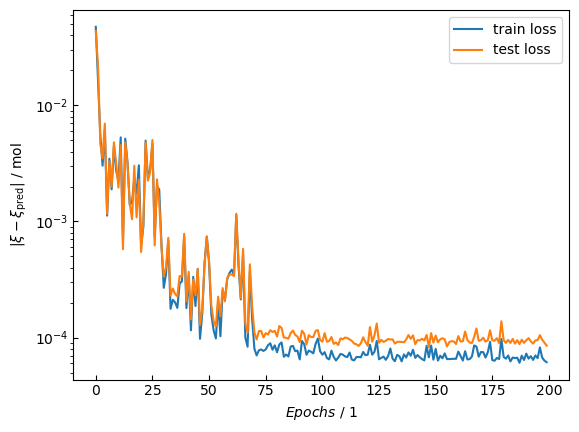

In [9]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
#plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '|$\\xi - \\xi\mathregular{_{pred}}$| / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.show()

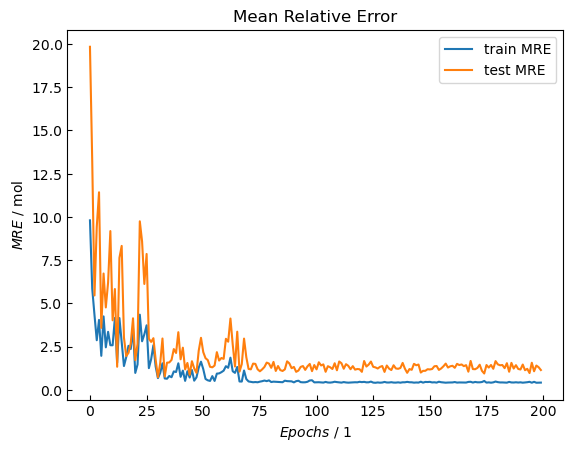

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_MRE, label='train MRE')
ax.plot(test_MRE, label='test MRE')
plt.title("Mean Relative Error")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.show()

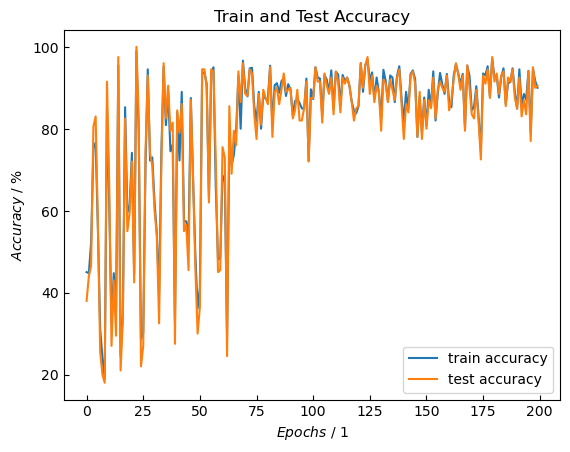

In [11]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.show()

#### Debugging Hilfe

In [12]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y.reshape((-1,1)))
    print(net(X))
    break

tensor([[7.2403e+02, 1.3865e+02, 7.2111e-02, 4.4622e-02, 8.8327e-01],
        [7.1300e+02, 2.0419e+02, 4.0541e-01, 3.0591e-01, 2.8868e-01],
        [7.6625e+02, 1.1368e+02, 1.4112e-01, 2.6104e-01, 5.9784e-01],
        [7.4615e+02, 2.1053e+02, 3.3816e-01, 5.0637e-01, 1.5547e-01],
        [6.6285e+02, 2.2195e+02, 3.1569e-01, 2.9775e-01, 3.8656e-01],
        [7.8863e+02, 1.9505e+02, 6.6970e-01, 1.3105e-01, 1.9925e-01],
        [6.9987e+02, 1.6659e+02, 5.2364e-01, 8.3560e-02, 3.9280e-01],
        [7.3913e+02, 2.3036e+02, 3.0244e-01, 3.3346e-01, 3.6409e-01],
        [8.1218e+02, 2.3451e+02, 2.6669e-01, 6.7555e-01, 5.7764e-02],
        [8.2536e+02, 2.4577e+02, 2.0508e-01, 7.4219e-01, 5.2735e-02],
        [7.9452e+02, 1.4508e+02, 4.4277e-03, 6.0441e-01, 3.9116e-01],
        [7.0290e+02, 1.5607e+02, 1.6307e-01, 2.8619e-01, 5.5074e-01],
        [7.0669e+02, 2.1793e+02, 5.6409e-01, 2.7294e-01, 1.6297e-01],
        [7.2062e+02, 1.0367e+02, 7.4747e-01, 5.4824e-02, 1.9771e-01],
        [7.1670e+02,

#### Einblick in Netzwerk

In [13]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([0.9939, 1.0319, 0.8785, 1.1535, 0.9035], requires_grad=True),
 Parameter containing:
 tensor([ 0.0674,  0.1043, -0.0684, -0.1285,  0.0844], requires_grad=True),
 Parameter containing:
 tensor([[-0.0854,  0.2886,  0.1805,  0.2170,  0.1750],
         [-0.2407, -0.0952, -0.1693,  0.2157, -0.3281],
         [ 0.4392,  0.0755,  0.0557,  0.4246, -0.0900],
         [-0.0513, -0.0858,  0.1835,  0.3800,  0.2694],
         [-0.0931, -0.0744, -0.4990,  0.5902, -0.3306],
         [-0.2003,  0.2793,  0.0779,  0.3396, -0.2656],
         [ 0.1931,  0.3128,  0.1769,  0.2891,  0.2829],
         [ 0.0559,  0.0618, -0.3665,  0.5300, -0.2607],
         [-0.1369, -0.0521,  0.1404, -0.3690,  0.3007],
         [-0.3876,  0.3150,  0.2648,  0.2868,  0.2542],
         [-0.2255, -0.3086, -0.1215,  0.2285,  0.1868],
         [-0.0270, -0.1265,  0.3583, -0.0515,  0.4226],
         [-0.0122, -0.3844,  0.1425,  0.0795, -0.0486],
         [ 0.0248, -0.3902, -0.0733,  0.0293, -0.0469],


In [14]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.4906, 0.3988, 0.1610, 0.6904, 0.1314],
        [0.5075, 0.9877, 0.4041, 0.6610, 0.3301]])
tensor([[-0.0292],
        [-0.1278]], grad_fn=<AddmmBackward0>)


In [15]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [16]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    break

tensor([[8.0225e+02, 2.0056e+02, 4.2743e-02, 2.1527e-01, 7.4199e-01],
        [6.7977e+02, 1.5663e+02, 1.2510e-01, 3.8871e-01, 4.8619e-01],
        [6.9465e+02, 1.8040e+02, 3.9906e-01, 2.4038e-01, 3.6056e-01],
        [8.1236e+02, 1.4067e+02, 1.1106e-01, 3.4143e-02, 8.5480e-01],
        [7.6015e+02, 1.3508e+02, 4.5431e-01, 9.7340e-02, 4.4835e-01],
        [8.4591e+02, 1.7150e+02, 4.7691e-02, 4.9042e-01, 4.6189e-01],
        [7.5781e+02, 2.1868e+02, 1.5746e-01, 8.1929e-01, 2.3259e-02],
        [7.5862e+02, 1.7485e+02, 1.5761e-01, 6.1753e-01, 2.2485e-01],
        [6.5173e+02, 2.1747e+02, 8.7537e-01, 1.0075e-01, 2.3875e-02],
        [7.9993e+02, 1.6369e+02, 1.2379e-02, 8.2223e-01, 1.6539e-01],
        [6.8103e+02, 2.4609e+02, 5.5701e-01, 2.1993e-01, 2.2306e-01],
        [6.5050e+02, 1.3774e+02, 1.1137e-02, 2.1225e-01, 7.7661e-01],
        [7.8081e+02, 1.8195e+02, 1.2467e-01, 6.8346e-01, 1.9187e-01],
        [6.8813e+02, 1.7149e+02, 5.6401e-01, 2.6631e-01, 1.6969e-01],
        [7.1241e+02,